In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import numpy as np
from pyspark import SparkContext, SparkFiles
import string
import matplotlib.pyplot as plt

sc = SparkContext('local','Kmeans')

In [ ]:
centroids = sc.textFile('centroid.txt')
data = sc.textFile('data.txt')

Function to calculate closest index from point and current centroids

In [ ]:
def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

**Kmeans Implementation**

I did some debugging and I can tell the centroids move locations and some points get updated to new centroids. Obviously, the graph of my loss function is basically static. I think the issue is in how I'm calculating the loss from my RDD object. I have confirmed that the centroid points update locations and seem to converge. You can see this by uncommenting the print(newCentroids) line. Thanks for the conisderation.

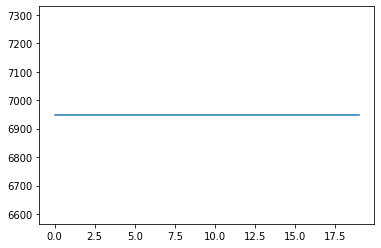

In [ ]:
clean_c = centroids.map(lambda line: line.split('\t')).map(lambda line: [float(x) for x in line]) # parse centroids
clean_d = data.map(lambda line: line.split('\t')).map(lambda line: [float(x) for x in line]) # parse data points
c_array = np.array(clean_c.collect()) #array of current centroids

num_iters = 0;
costArray = []; # array to calculate loss for plot

while num_iters < 20:
  closest = clean_d.map(lambda p: (closestPoint(p, c_array), (p, 1)))
  # Maps data points, format: (closest centroid number, (point array, key value))

  intermediate = closest.reduceByKey(lambda a,b: ((np.add(a[0], b[0]), np.add(a[1], b[1]))))
  # Reduce by key, adds up point array to get totals per dimension and adds counts per centroid

  newCentroids = intermediate.mapValues(lambda x: (np.divide(x[0], x[1]))).values().collect()
  # Calculates new centroids by dividing each dimension point in the array by the count of points at that centroid
  
  #print(newCentroids)
  #use this to print the array of centroid locations for each pass, you can see they update and then seem to converge
  
  c_array = (newCentroids) # Updates centroid locations
  num_iters +=1

  totalDistArray = intermediate.mapValues(lambda d: np.sum(d[0])).values().collect()
  totalDist = np.sum(totalDistArray) # Finds total distance of points to nearest centroid for that iteration
  costArray.append(totalDist) # Adds total distance to loss array for plotting


x_val = list(range(0, 20))
plt.plot(x_val, costArray) # Plots loss function